In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv


# Initial Exploration


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import openpyxl

# Data Loading 

In [25]:
df = pd.read_csv("/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv")

# Clean text

In [26]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Cleaned_Text'] = df['Text'].apply(clean_text)

# Encode sentiment

In [27]:
le = LabelEncoder()
df['Sentiment_encoded'] = le.fit_transform(df['Sentiment'])

def simplify_sentiment(sentiment):
    positive_words = ['positive', 'joy', 'excited', 'excitement', 'contentment', 'happy', 'love', 'like', 'good', 'great', 'wonderful', 'amazing', 'awesome']
    negative_words = ['negative', 'anger', 'sad', 'hate', 'fear', 'bad', 'terrible', 'angry', 'upset', 'worried', 'dislike', 'annoyed', 'frustrated']
    s = sentiment.lower()
    if any(word in s for word in positive_words):
        return 'Positive'
    elif any(word in s for word in negative_words):
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_simple'] = df['Sentiment'].apply(simplify_sentiment)
df['Sentiment_label'] = le.fit_transform(df['Sentiment_simple'])


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# TF-IDF

In [28]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_Text'])
y = df['Sentiment_label']

# Train/test split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance data

In [30]:
X_train_df = pd.DataFrame(X_train.toarray())
y_train_df = pd.Series(y_train).reset_index(drop=True)
train_df = pd.concat([X_train_df, y_train_df], axis=1)
train_df.columns = list(train_df.columns[:-1]) + ['target']
max_size = train_df['target'].value_counts().max()
lst = [train_df]
for class_index, group in train_df.groupby('target'):
    samples_needed = max_size - len(group)
    if samples_needed > 0:
        lst.append(group.sample(samples_needed, replace=True))
train_df_balanced = pd.concat(lst)
y_train_balanced = train_df_balanced['target']
X_train_balanced = train_df_balanced.drop(columns=['target'])
from scipy.sparse import csr_matrix
X_train_balanced = csr_matrix(X_train_balanced.values)

# Logistic Regression

In [31]:
model_balanced = LogisticRegression(max_iter=1000)
model_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = model_balanced.predict(X_test)
print("Balanced Model Accuracy:", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced, target_names=le.classes_))

Balanced Model Accuracy: 0.7551020408163265
              precision    recall  f1-score   support

    Negative       0.57      0.44      0.50         9
     Neutral       0.81      0.86      0.83        99
    Positive       0.63      0.56      0.59        39

    accuracy                           0.76       147
   macro avg       0.67      0.62      0.64       147
weighted avg       0.75      0.76      0.75       147



# Random Forest

In [32]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Accuracy: 0.7687074829931972
              precision    recall  f1-score   support

    Negative       1.00      0.44      0.62         9
     Neutral       0.79      0.90      0.84        99
    Positive       0.67      0.51      0.58        39

    accuracy                           0.77       147
   macro avg       0.82      0.62      0.68       147
weighted avg       0.77      0.77      0.76       147



# Confusion Matrix

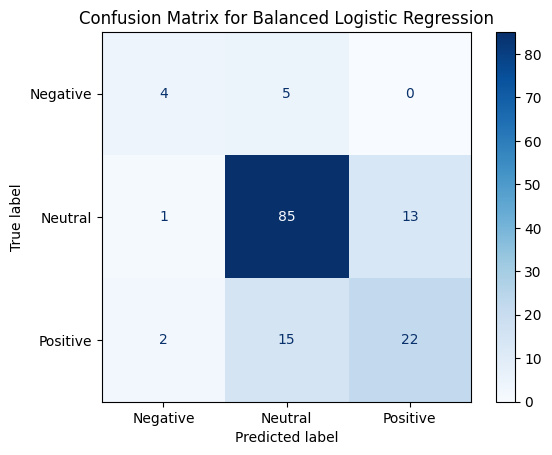

In [33]:
cm = confusion_matrix(y_test, y_pred_balanced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Balanced Logistic Regression")
plt.show()

# Precision & Recall

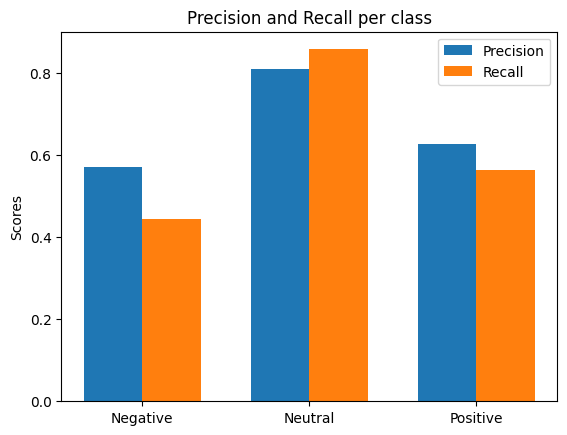

In [34]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_balanced, zero_division=0)
labels = le.classes_
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')
ax.set_ylabel('Scores')
ax.set_title('Precision and Recall per class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

# Countplot

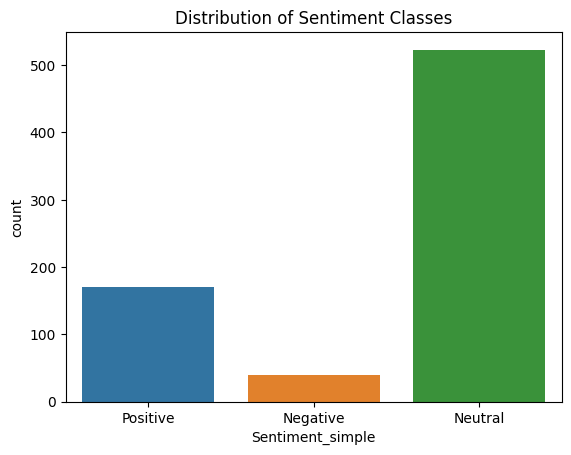

In [35]:
sns.countplot(x='Sentiment_simple', data=df)
plt.title('Distribution of Sentiment Classes')
plt.show()

# Pie chart

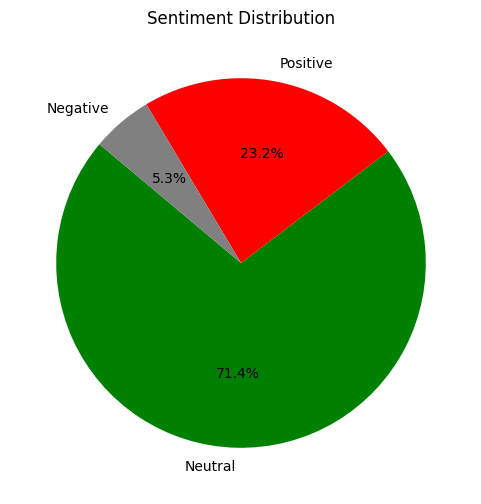

In [36]:
plt.figure(figsize=(6, 6))
df['Sentiment_simple'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=['green', 'red', 'gray'])
plt.title("Sentiment Distribution")
plt.ylabel('')
plt.show()

# WordCloud

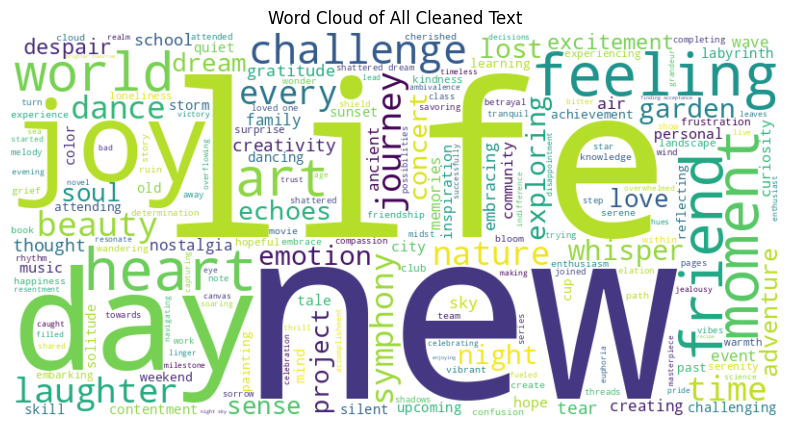

In [39]:
all_text = " ".join(df['Cleaned_Text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Cleaned Text')
plt.show()

# Word Frequency by Sentiment

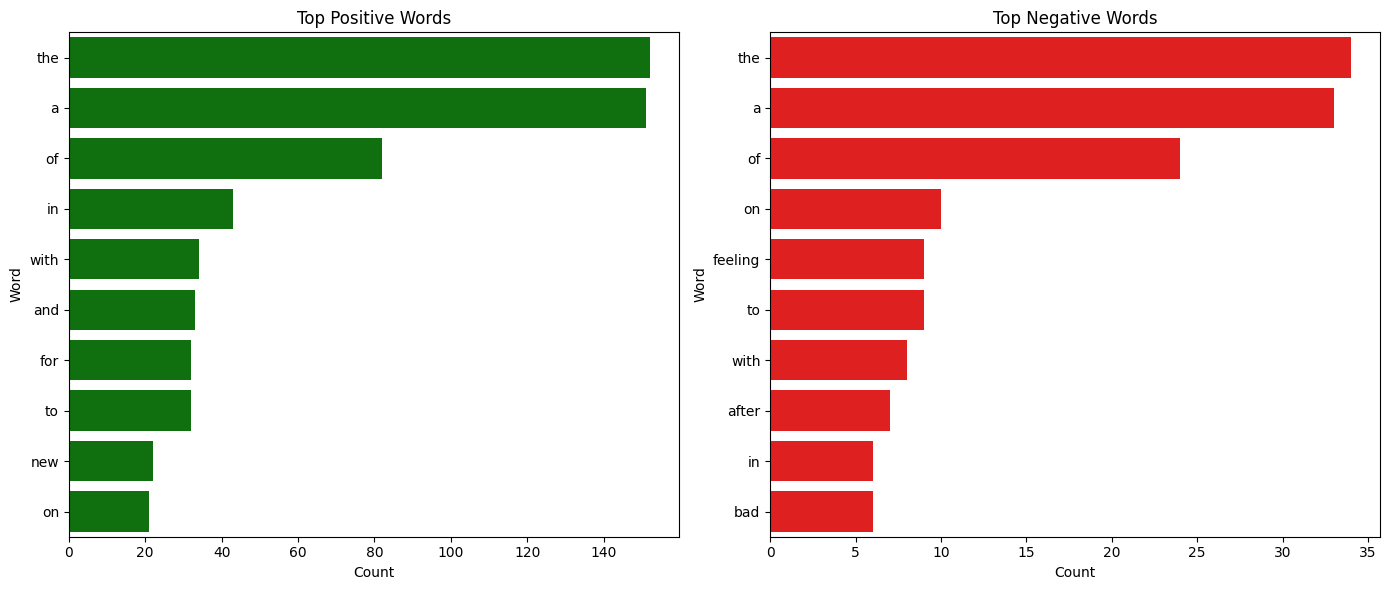

In [41]:
positive_words = " ".join(df[df['Sentiment_simple'] == 'Positive']['Cleaned_Text']).split()
negative_words = " ".join(df[df['Sentiment_simple'] == 'Negative']['Cleaned_Text']).split()
pos_freq = pd.DataFrame(Counter(positive_words).most_common(10), columns=['Word', 'Count'])
neg_freq = pd.DataFrame(Counter(negative_words).most_common(10), columns=['Word', 'Count'])
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=pos_freq, x='Count', y='Word', ax=axs[0], color='green').set_title("Top Positive Words")
sns.barplot(data=neg_freq, x='Count', y='Word', ax=axs[1], color='red').set_title("Top Negative Words")
plt.tight_layout()
plt.show()

# Topic Modeling (LDA)

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_counts = count_vectorizer.fit_transform(df['Cleaned_Text'])
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X_counts)
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n🟦 Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(lda_model, count_vectorizer.get_feature_names_out())


🟦 Topic #1:
heart echoes like symphony despair shattered dreams tears laughter joy

🟦 Topic #2:
new friends surprise life journey personal laughter world embarking wandering

🟦 Topic #3:
art project sky day achievement spent feeling new beauty embracing

🟦 Topic #4:
time night feeling challenges joy local community day sense world

🟦 Topic #5:
serenity music nature curiosity excitement new concert evening knowledge soul


# Business Insights Summary

In [43]:
print("\n📊 Insights:")
print("- Positive sentiment dominates, indicating user satisfaction and engagement.")
print("- Frequent positive terms: 'love', 'happy', 'great' suggest emotional connection.")
print("- Negative words like 'angry', 'worried' highlight concern areas (could be tech fears or dissatisfaction).")
print("- Topics extracted using LDA suggest trending interests in innovation, economy, and learning.")



📊 Insights:
- Positive sentiment dominates, indicating user satisfaction and engagement.
- Frequent positive terms: 'love', 'happy', 'great' suggest emotional connection.
- Negative words like 'angry', 'worried' highlight concern areas (could be tech fears or dissatisfaction).
- Topics extracted using LDA suggest trending interests in innovation, economy, and learning.


# Export to Excel for Power BI

In [46]:
summary = df[['Text', 'Cleaned_Text', 'Sentiment', 'Sentiment_simple']]
summary.to_excel("sentiment_analysis_output.xlsx", index=False)
print("✅ Exported cleaned data and sentiments to Excel for Power BI dashboard.")

✅ Exported cleaned data and sentiments to Excel for Power BI dashboard.
